In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



<ipython-input-22-35012220dad7>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_images = torch.tensor([image.numpy() for image, label in train_dataset])


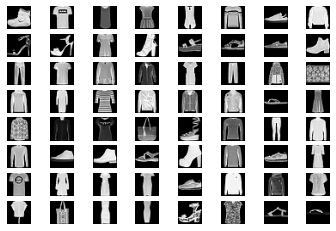

In [22]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

In [28]:
x_train=torch.tensor([image.numpy() for image, label in train_dataset if label==2 or label==6])
x_test=torch.tensor([image.numpy() for image, label in test_dataset if label==2 or label==6])
x_train=np.array(x_train)
x_test=np.array(x_test)

y_train_i=torch.tensor([label for image, label in train_dataset if label==2 or label==6])
y_test_i=torch.tensor([label for image, label in test_dataset if label==2 or label==6])
y_train_i=np.array(y_train_i)
y_test_i=np.array(y_test_i)

# write your code here

In [29]:
y_train=[]
y_test=[]
for i in y_train_i:
    if(i==2):
        y_train.append(0)
    else:
        y_train.append(1)
for i in y_test_i:
    if(i==2):
        y_test.append(0)
    else:
        y_test.append(1)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [30]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(12000, 1, 28, 28) (12000,)
(2000, 1, 28, 28) (2000,)


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [32]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [33]:
x_train_small=x_train[random_sample]
print(x_train_small.shape)
print(x_train.shape)
y_train_small=y_train[random_sample]
print(y_train_small.shape)
print(y_train.shape)
# write your code here

(1000, 1, 28, 28)
(12000, 1, 28, 28)
(1000,)
(12000,)


In [36]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt',map_location=torch.device('cpu')))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [37]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

In [38]:
print(x_train_small.shape)
print(x_train_small_bottleneck_representation.shape)
x_train_small_bottleneck_representation=np.array(x_train_small_bottleneck_representation)
print(type(x_train_small_bottleneck_representation))

(1000, 1, 28, 28)
torch.Size([1000, 84])
<class 'numpy.ndarray'>


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.653122
[t-SNE] KL divergence after 1000 iterations: 1.065626


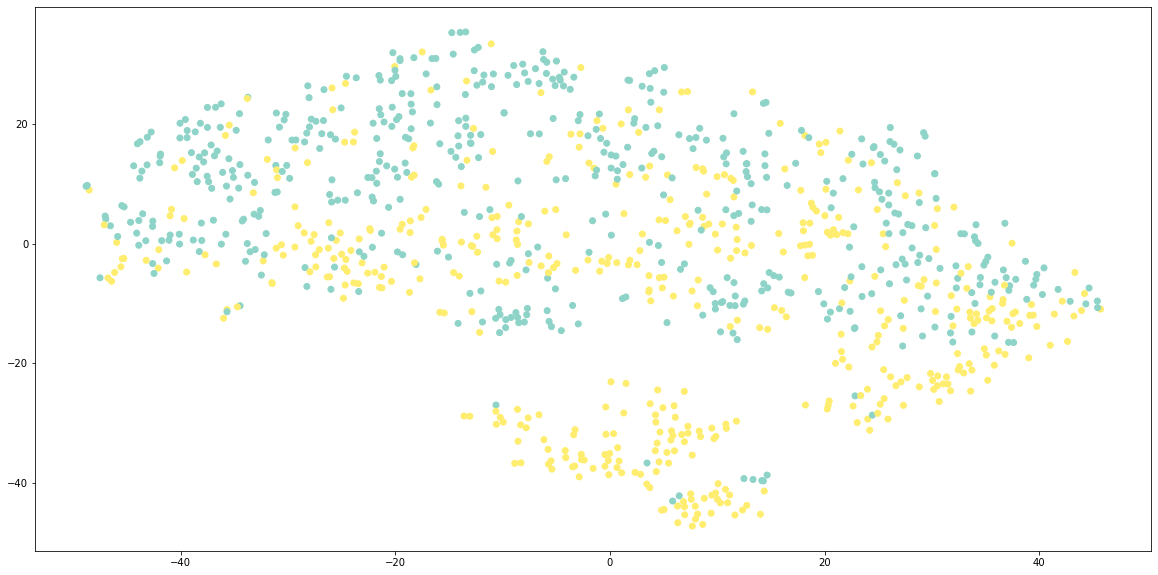

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.945068
[t-SNE] KL divergence after 1000 iterations: 0.994312


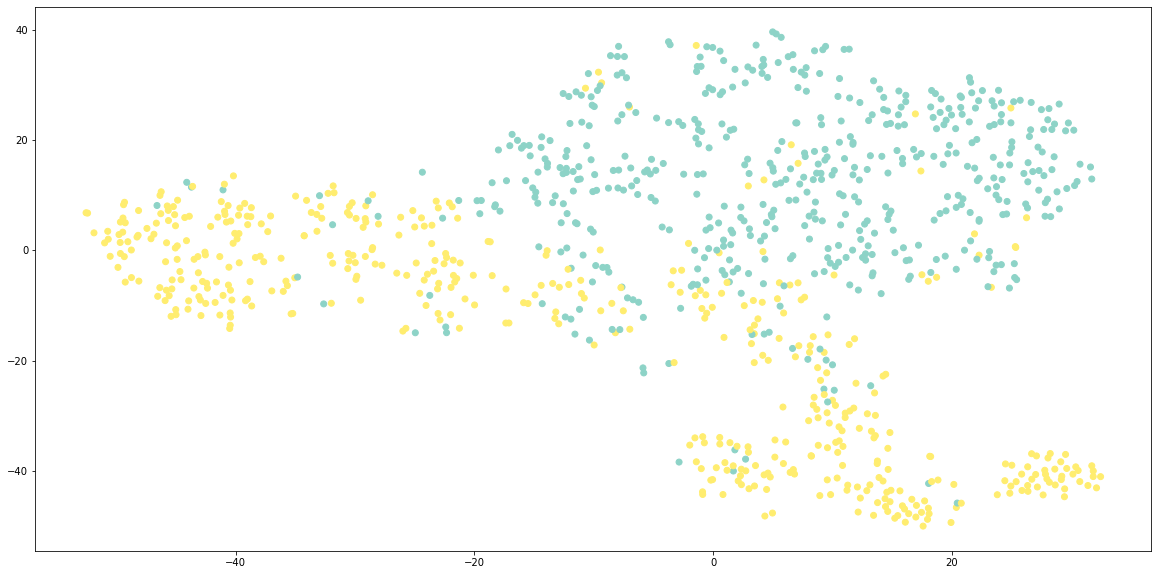

In [41]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=25,verbose=1,random_state=0)
x_train_small=x_train_small.reshape(1000,784)

x_train_small_2d_tsne = tsne.fit_transform(x_train_small)
plt.figure(figsize=(20,10))
#for i in range(10):
plt.scatter(x_train_small_2d_tsne[:,0],x_train_small_2d_tsne[:,1],c=y_train_small,cmap='Set3')
plt.show()
    





tsne1 = TSNE(n_components=2, perplexity=25,verbose=1,random_state=0)
#x_train_small_bottleneck_representation=x_train_small_bottleneck_representation.reshape(1000,84)
x_train_small_bottleneck_representation_2d_tsne = tsne1.fit_transform(x_train_small_bottleneck_representation)
plt.figure(figsize=(20,10))
#for i in range(10):

plt.scatter(x_train_small_bottleneck_representation_2d_tsne[:,0],x_train_small_bottleneck_representation_2d_tsne[:,1],c=y_train_small,cmap='Set3')
plt.show()
# write your code here

In [42]:
train_images=np.array(train_images)
print(type(train_images))

<class 'numpy.ndarray'>


In [50]:
#Getting bottleneck features for all training data for the classifiers to fit on
#x_train_i=x_train.reshape(12000,1,28,28)
#print(x_test.shape)
x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)
#print(x_train_bottleneck_representation.shape)
#x_train_bottleneck_representation=np.array(x_train_bottleneck_representation)
x_test_bottleneck_representation=np.array(x_test_bottleneck_representation)
print(x_test_bottleneck_representation.shape)
#print(x_test.shape)
# write your code here

(2000, 84)


In [51]:
x_test_raw=x_test.reshape(2000,784)
x_train_i=x_train.reshape(12000,784)
x_test_i=x_test.reshape(2000,784)

In [52]:
print(x_test_i.shape)
print(x_train_i.shape)
print(y_test.shape)
print(y_train.shape)
print(x_test_bottleneck_representation.shape)
x_train_bottleneck_representation=np.array(x_train_bottleneck_representation)
print(x_train_bottleneck_representation.shape)

(2000, 784)
(12000, 784)
(2000,)
(12000,)
(2000, 84)
(12000, 84)


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
rf1=RandomForestClassifier(n_estimators=100, random_state=0)
rf1.fit(x_train_i,y_train)

rf2=RandomForestClassifier(n_estimators=100, random_state=0)
rf2.fit(x_train_bottleneck_representation,y_train)

classifier1=KNeighborsClassifier(n_neighbors=5)
classifier1.fit(x_train_i,y_train)

classifier2=KNeighborsClassifier(n_neighbors=5)
classifier2.fit(x_train_bottleneck_representation,y_train)

#Testing Accuracies

y_pred = rf1.predict(x_test_i)
print("Accuracy Using RF on all features:",accuracy_score(y_test, y_pred))

y_pred = rf2.predict(x_test_bottleneck_representation)
print("Accyracy Using RF on bottleneck features:",accuracy_score(y_test, y_pred))

y_pred = classifier1.predict(x_test_i)
print("Accuracy Using KNN on all features:",accuracy_score(y_test, y_pred))

y_pred = classifier2.predict(x_test_bottleneck_representation)
print("Accuracy Using KNN on bottleneck features:",accuracy_score(y_test, y_pred))


# write your code here

Accuracy Using RF on all features: 0.8765
Accyracy Using RF on bottleneck features: 0.898
Accuracy Using KNN on all features: 0.856
Accuracy Using KNN on bottleneck features: 0.888


In [54]:
#Convnet Prediction
proba=UDA_pytorch_model_transform(convnet,x_test, device=None, batch_size=128,
                                sequence=False)
predicted_labels=[]
for p in proba:
    predicted_labels.append(np.argmax([np.array(p)[2],np.array(p)[6]]))
    
predicted_labels=np.array(predicted_labels)    

test_error = np.mean(predicted_labels != y_test)
print("Accuracy for Pre-Trained Neural Net- ",1-test_error)

Accuracy for Pre-Trained Neural Net-  0.891


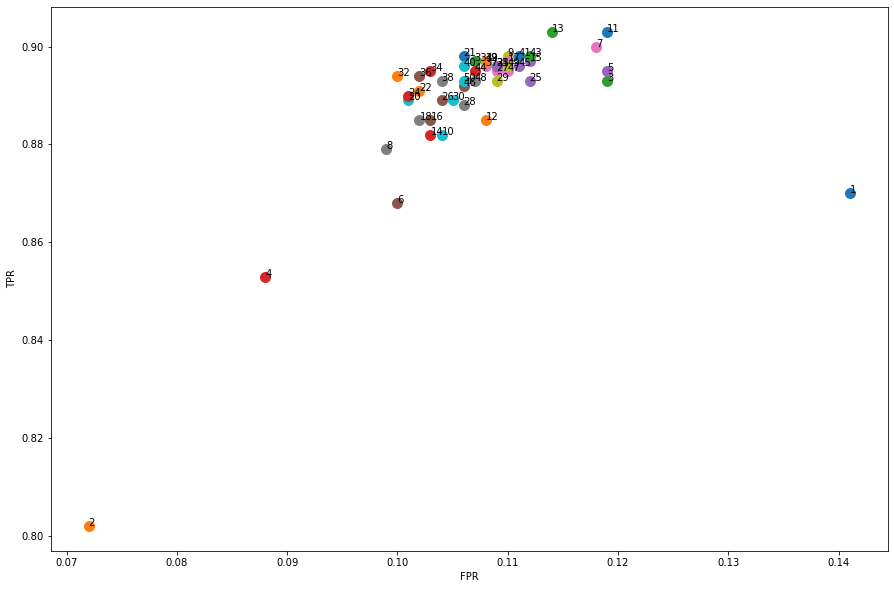

In [55]:
#Part D
a=[]
b=[]
for k in range(1,51):
    classifier=KNeighborsClassifier(n_neighbors=k)
    classifier.fit(x_train_bottleneck_representation, y_train)
    y_pred = classifier.predict(x_test_bottleneck_representation)
    # a = f1_score(y_test, y_pred,average='weighted')
    #fold_scores.append(a)
    fpr_k, tpr_k, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    #print(fpr_k[1])
    a.append([fpr_k[1],k])
    b.append([tpr_k[1],k])

plt.figure(figsize=(15,10))
#print(a[1][0])
#print(b)
n=np.arange(50)
for i in range(0,50):
     plt.scatter(a[i][0],b[i][0],s=100)
     #plt.annotate(str(i+1),xy =(float(a[i][0], float(b[i][0])))
     plt.xlabel("FPR")
     plt.ylabel("TPR")

for i, txt in enumerate(n):
    plt.annotate(i+1, (a[i][0], b[i][0]))